# Train, store and deploy tensorflow model on Watson Machine Learning service

##### Pipeline for Training and deploying with Watson Machine Learning.
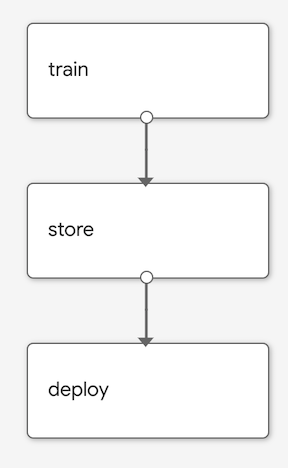

### Model for this pipeline
We will be training a TensorFlow model that can classify the handwritten digits. This TensorFlow model is a simple convolutional neural network (CNN) with 2 convolutional layers and 1 fully connected layers using the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. We will be training for 200,000 iterations for the purpose of this demo.

<br><br>

Prior to run this pipeline, need to update the cluster role binding from pipeline-runner to cluster-admin. This is one time modification to the Kubeflow Pipelines service. It allows the secrets to be created inside the container.

In [ ]:
# install the SDK
KFP_PACKAGE = 'https://storage.googleapis.com/ml-pipeline/release/0.1.21/kfp.tar.gz'
!pip install $KFP_PACKAGE --upgrade

In [ ]:
# install ai_pipeline_params package
!pip install ai_pipeline_params --upgrade --no-cache-dir

Prereq: users provide the credentials to access the Watson Machine Learning service as well as the S3 Cloud Storage in a <key = value> pair text file. Then run the **create-secret.ipynb** notebook to create the credentials as secret.

In [ ]:
# define secret name
secret_name = 'ai-pipeline-creds'

* Create an experiment

In [ ]:
# set up
EXPERIMENT_NAME = 'Watson Machine Learning Experiment'

In [ ]:
# create experiment
import kfp

client = kfp.Client()
exp = client.create_experiment(name=EXPERIMENT_NAME)

* Construct the pipeline

In [ ]:
# create pipelines
import kfp
from kfp import components
from kfp import dsl
import ai_pipeline_params as params

train_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/ibm-components/watson/train/component.yaml')
store_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/ibm-components/watson/store/component.yaml')
deploy_op = components.load_component_from_url('https://raw.githubusercontent.com/kubeflow/pipelines/master/components/ibm-components/watson/deploy/component.yaml')

# create pipelines

@dsl.pipeline(
    name='KFP on WML training',
    description='Kubeflow pipelines running on WML performing tensorflow image recognition.'
)
def kfp_wml_pipeline(
    train_code='tf-model.zip',
    execution_command='\'python3 convolutional_network.py --trainImagesFile ${DATA_DIR}/train-images-idx3-ubyte.gz --trainLabelsFile ${DATA_DIR}/train-labels-idx1-ubyte.gz --testImagesFile ${DATA_DIR}/t10k-images-idx3-ubyte.gz --testLabelsFile ${DATA_DIR}/t10k-labels-idx1-ubyte.gz --learningRate 0.001 --trainingIters 20000\'',
    framework= 'tensorflow',
    framework_version = '1.13',
    runtime = 'python',
    runtime_version = '3.6',
    run_definition = 'wml-tensorflow-definition',
    run_name = 'wml-tensorflow-run',
    model_name='wml-tensorflow-mnist',
    scoring_payload='tf-mnist-test-payload.json'
):
    # op1 - this operation trains the model with the model codes and data saved in the cloud object store
    wml_train = train_op(
                   train_code=train_code,
                   execution_command=execution_command,
                   framework=framework,
                   framework_version=framework_version,
                   runtime=runtime,
                   runtime_version=runtime_version,
                   run_definition=run_definition,
                   run_name=run_name
                   ).apply(params.use_ai_pipeline_params(secret_name))

    # op2 - this operation stores the model trained above
    wml_store = store_op(
                   wml_train.outputs['run_uid'],
                   model_name
                  ).apply(params.use_ai_pipeline_params(secret_name))

    # op3 - this operation deploys the model to a web service and run scoring with the payload in the cloud object store
    wml_deploy = deploy_op(
                  wml_store.output,
                  model_name,
                  scoring_payload
                 ).apply(params.use_ai_pipeline_params(secret_name))

* Compile the pipeline

In [ ]:
# compile the pipeline
import kfp.compiler as compiler
pipeline_filename = kfp_wml_pipeline.__name__ + '.tar.gz'
compiler.Compiler().compile(kfp_wml_pipeline, pipeline_filename)

* Run the pipeline

In [ ]:
# run the pipeline
run_name = kfp_wml_pipeline.__name__ + ' run'
run_result = client.run_pipeline(exp.id, run_name, pipeline_filename)
import IPython
html = ('<p id="link"> </p> <script> document.getElementById("link").innerHTML = "Actual Run link <a href=//" + location.host + "%s/#/runs/details/%s target=_blank >here</a>"; </script>'
          % (client._get_url_prefix(), run_result.id))
IPython.display.HTML(html)

In [ ]:
# Show page with iframe
import IPython
html = ('<p id="web"> </p> <script> document.getElementById("web").innerHTML = "<iframe width=1100 height=700 src=http://" + location.host + "%s/#/runs/details/%s target=_blank >here</iframe>"; </script>'
          % (client._get_url_prefix(), run_result.id))
IPython.display.HTML(html)